# 필요한 라이브러리 import

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [3]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 공격수 EDA

In [5]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 확인

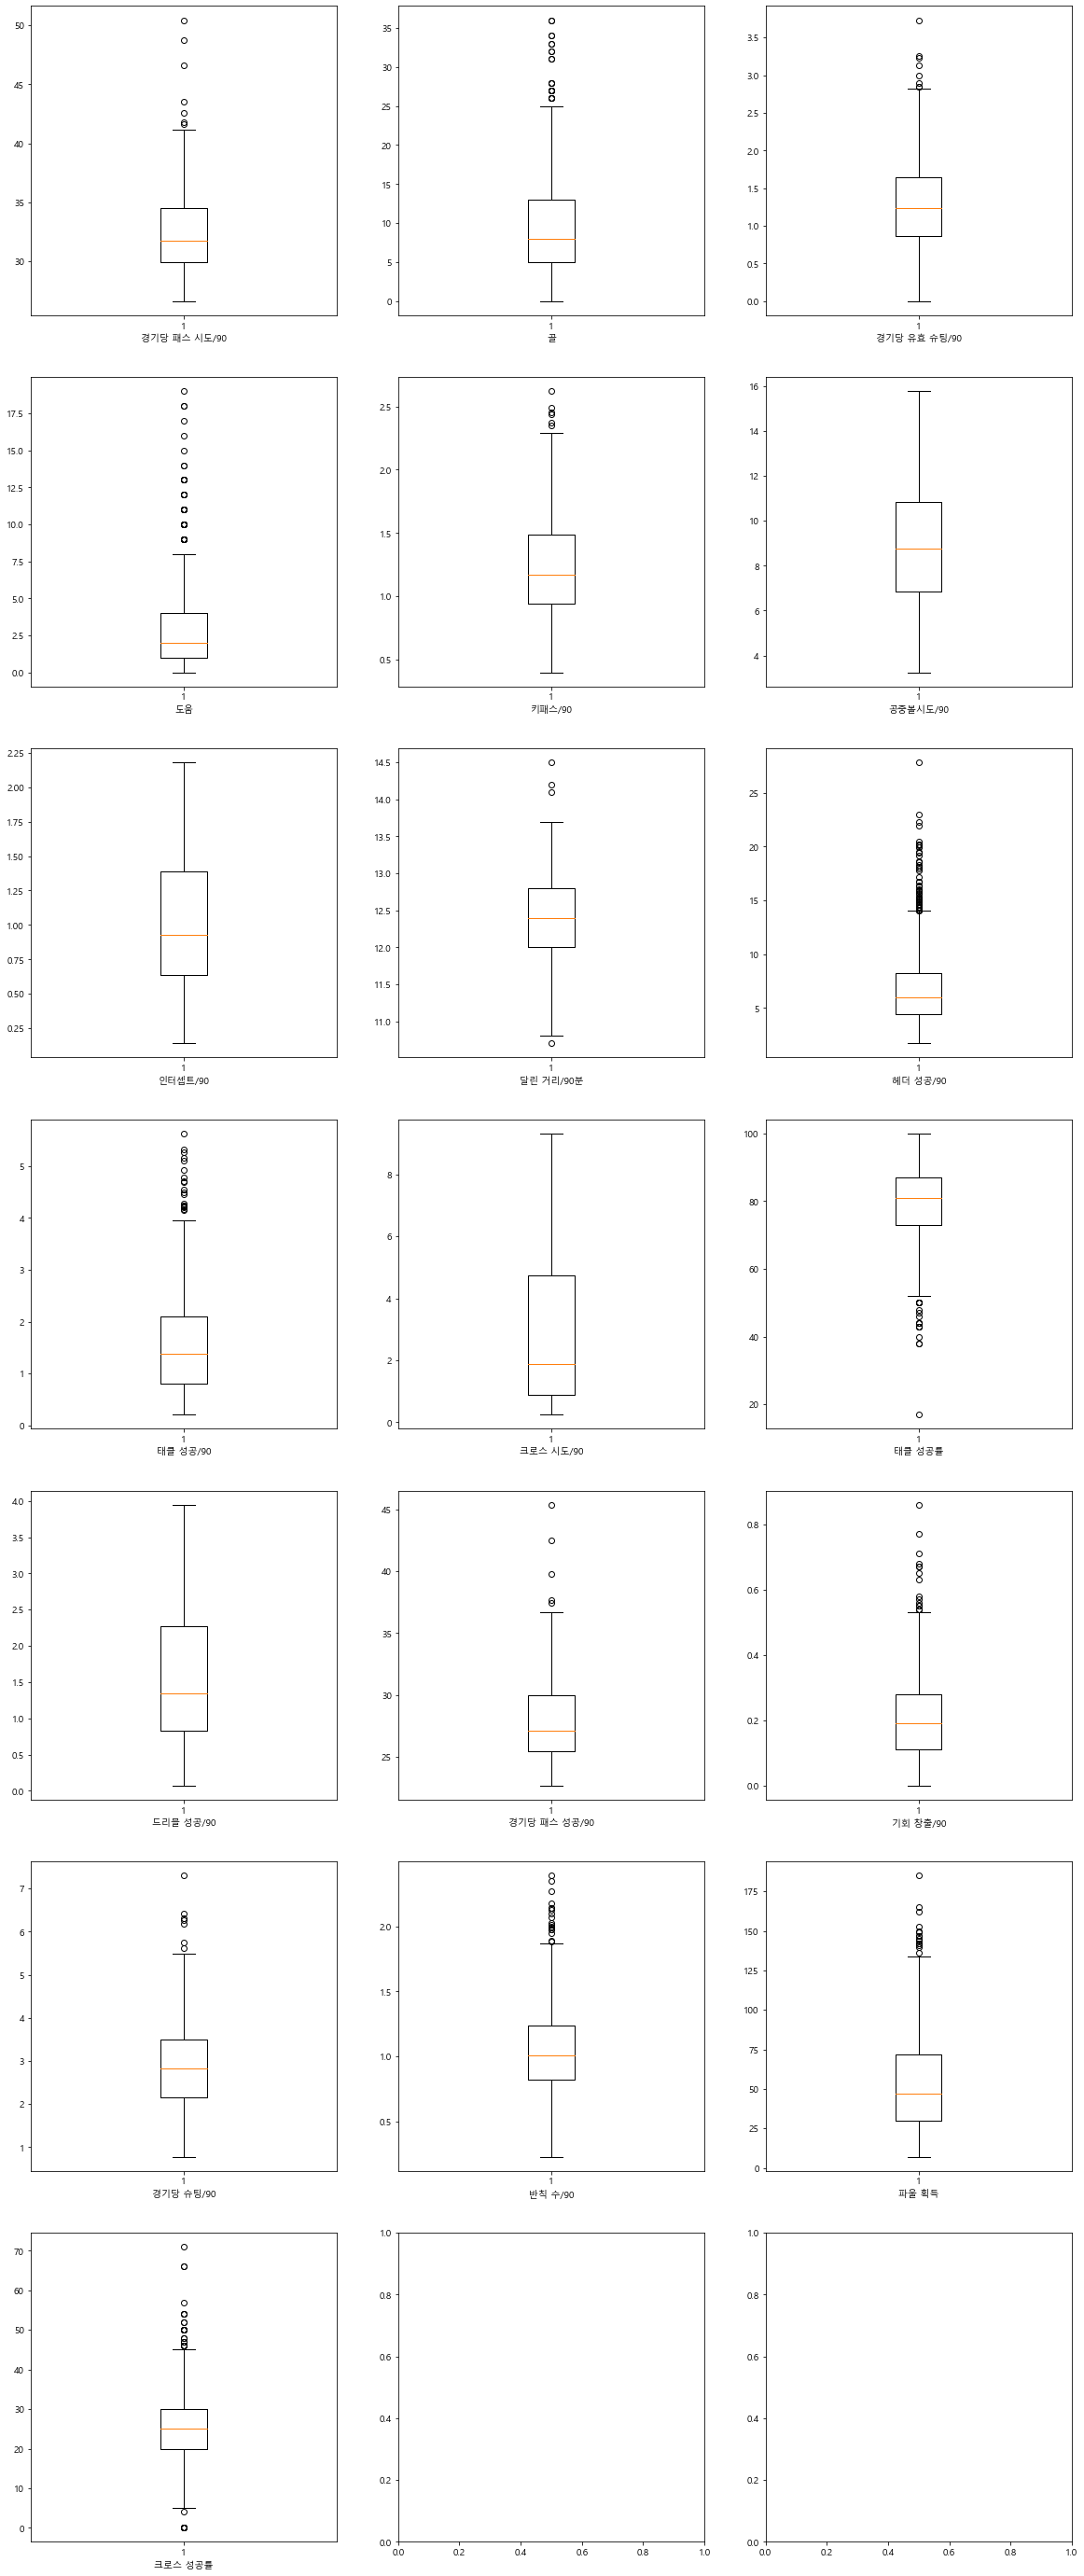

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

In [7]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)
    
sorted_outlier_ratio = sorted(out_ratio.items(),key=lambda x : x[1],reverse=True)

for k,v in sorted_outlier_ratio:
    print(f'{k}의 데이터 중 {np.round(v*100,3)}%가 이상치 입니다.')
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

헤더 성공/90의 데이터 중 16.364%가 이상치 입니다.
태클 성공/90의 데이터 중 8.283%가 이상치 입니다.
반칙 수/90의 데이터 중 6.465%가 이상치 입니다.
기회 창출/90의 데이터 중 6.061%가 이상치 입니다.
크로스 성공률의 데이터 중 5.859%가 이상치 입니다.
파울 획득의 데이터 중 5.657%가 이상치 입니다.
키패스/90의 데이터 중 3.838%가 이상치 입니다.
경기당 패스 시도/90의 데이터 중 3.434%가 이상치 입니다.
경기당 유효 슈팅/90의 데이터 중 3.434%가 이상치 입니다.
경기당 슈팅/90의 데이터 중 2.222%가 이상치 입니다.
경기당 패스 성공/90의 데이터 중 1.414%가 이상치 입니다.
크로스 시도/90의 데이터 중 1.212%가 이상치 입니다.
달린 거리/90분의 데이터 중 0.606%가 이상치 입니다.
드리블 성공/90의 데이터 중 0.202%가 이상치 입니다.
인터셉트/90의 데이터 중 0.0%가 이상치 입니다.
태클 성공률의 데이터 중 0.0%가 이상치 입니다.
공중볼시도/90의 데이터 중 0.0%가 이상치 입니다.


## 선형성 검정

### 선형성 시각화

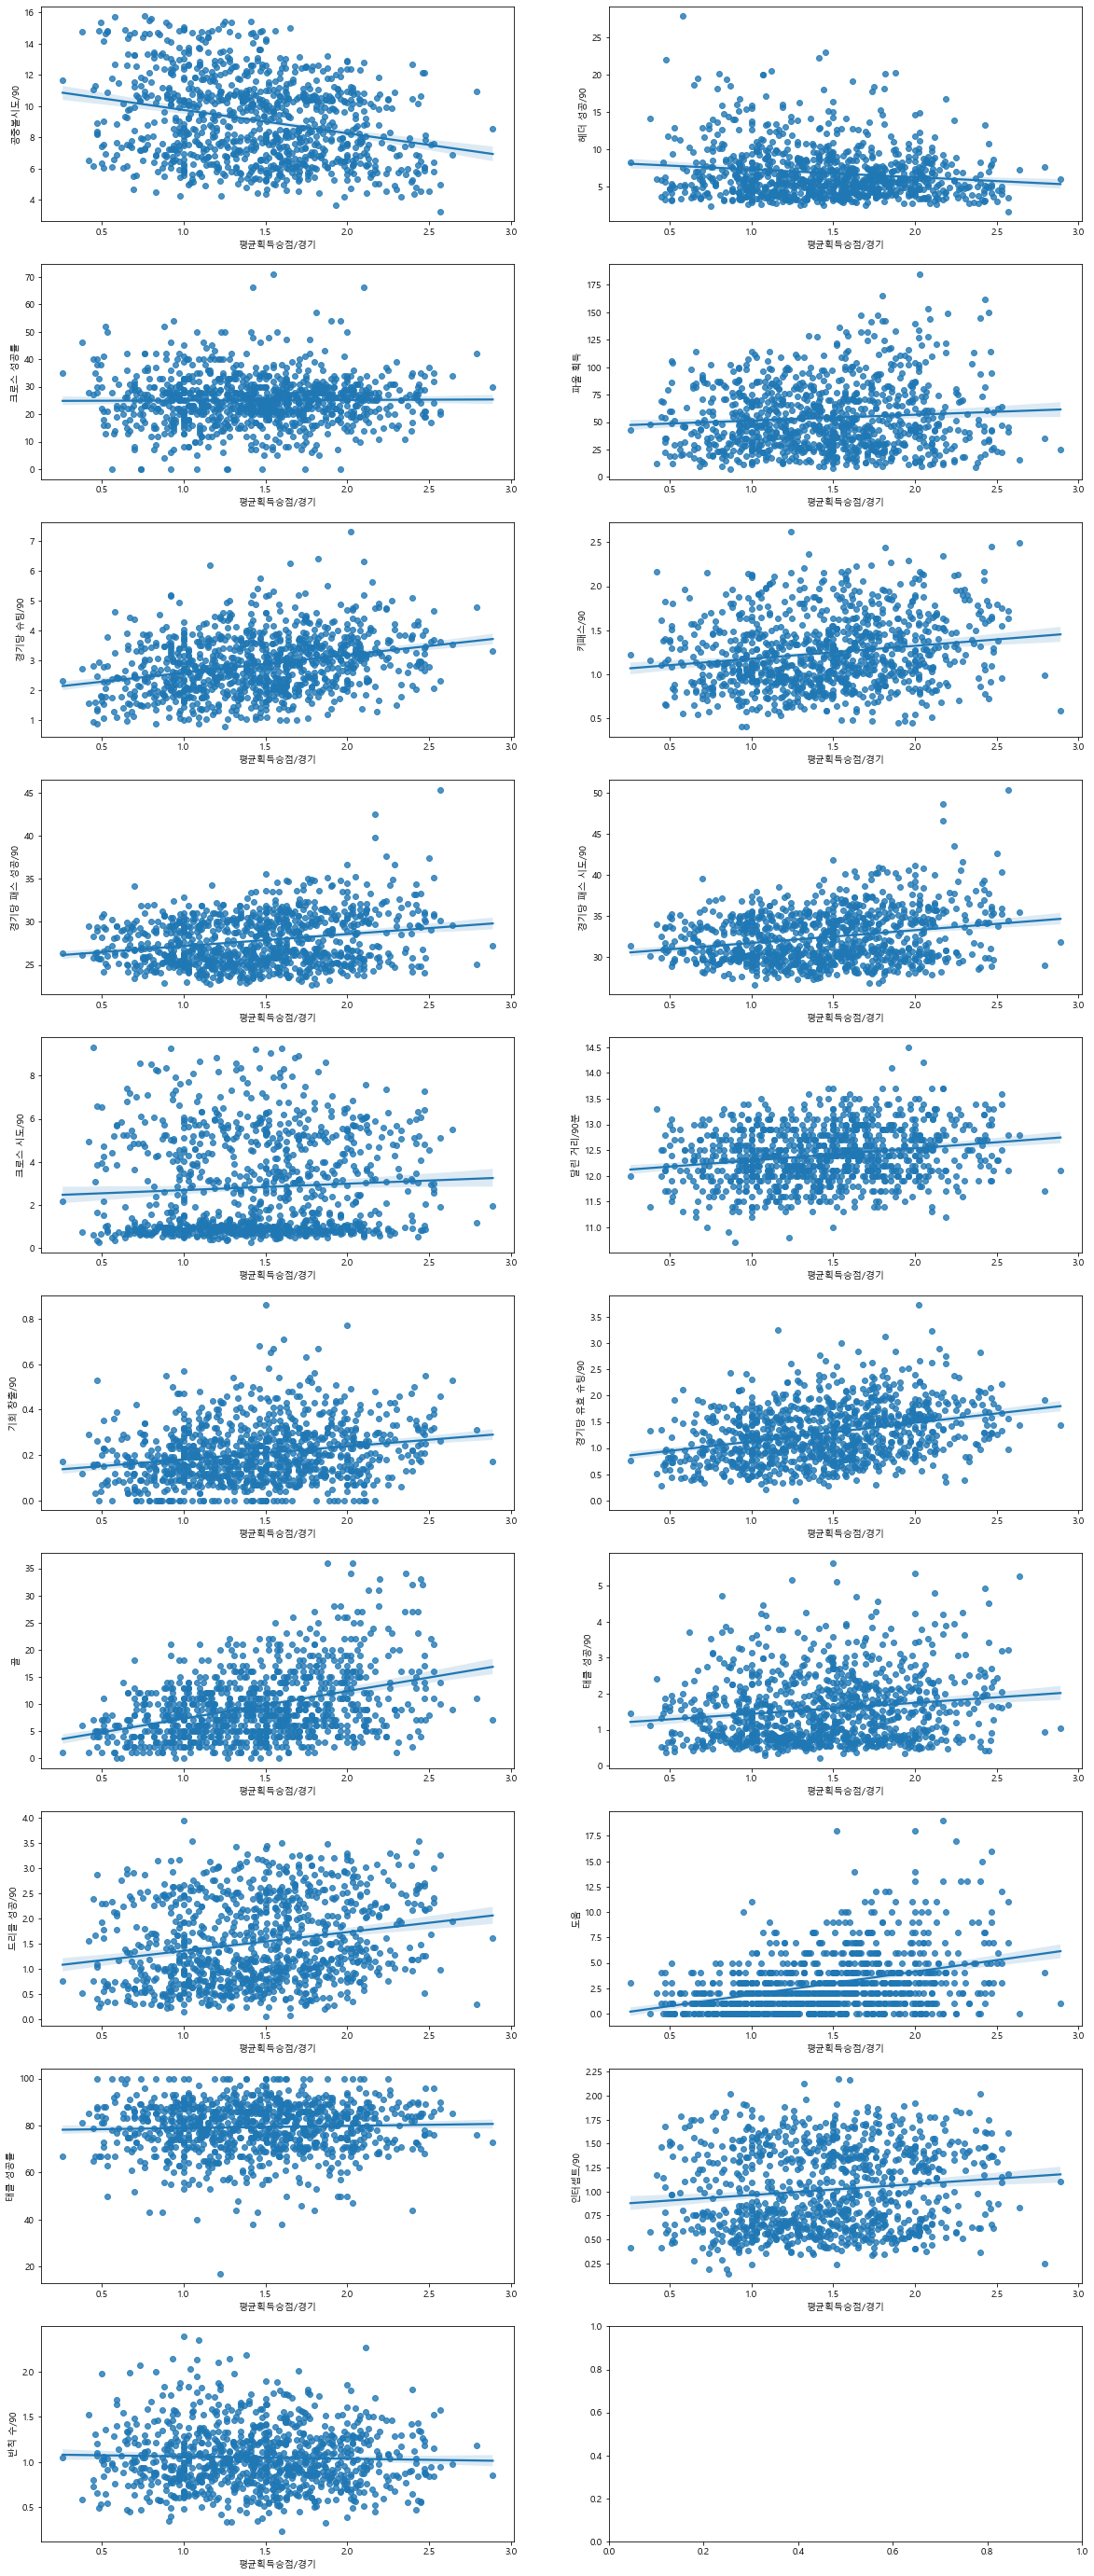

In [9]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

### 통계치로 선형성 확인

In [8]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

## 다중 공선성 확인

### VIF 확인

In [9]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.788092,도움
1,4.842201,기회 창출/90
2,9.795654,크로스 성공률
3,9.811395,크로스 시도/90
4,12.446589,반칙 수/90
5,12.987407,골
6,13.549914,태클 성공/90
7,15.434996,파울 획득
8,18.562202,헤더 성공/90
9,21.472031,드리블 성공/90


### 상관계수 확인

In [14]:
feature_comb = list(combinations(features,2))
corr_dict_pair = {}
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a}/{b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)

sorted(corr_dict_pair.items(),key=lambda x : np.abs(x[1][0]),reverse=True)

[('경기당 패스 시도/90/경기당 패스 성공/90', (0.9757693697539497, 0.0, False)),
 ('경기당 유효 슈팅/90/경기당 슈팅/90', (0.919756872041606, 0.0, False)),
 ('인터셉트/90/드리블 성공/90', (0.8391300965855942, 1.575944931151397e-263, False)),
 ('크로스 시도/90/드리블 성공/90', (0.7708906944851575, 9.660405634579921e-196, False)),
 ('태클 성공/90/크로스 시도/90', (0.770467867550075, 2.135887710775192e-195, False)),
 ('크로스 시도/90/경기당 패스 성공/90',
  (0.7637011554294952, 5.56153286098223e-190, False)),
 ('공중볼시도/90/드리블 성공/90', (-0.7587068459216181, 4.234980442630381e-186, False)),
 ('경기당 패스 시도/90/크로스 시도/90',
  (0.7550404243075445, 2.6099647502200166e-183, False)),
 ('인터셉트/90/크로스 시도/90', (0.7548551017529647, 3.6002599575132175e-183, False)),
 ('골/파울 획득', (0.7515666521498854, 1.0342071716269627e-180, False)),
 ('인터셉트/90/경기당 패스 성공/90',
  (0.7416773956981074, 1.5141215562247686e-173, False)),
 ('경기당 패스 시도/90/인터셉트/90', (0.729454879330766, 3.932290340169021e-165, False)),
 ('드리블 성공/90/경기당 패스 성공/90',
  (0.7153217222613918, 5.851830185097394e-156, False)),


### 삭제할 변수, 통합해야 할 변수 고르기

1. 삭제할 변수: 달린 거리/90분,태클 성공률,인터셉트/90,태클 성공/90, 반칙 수/90


2. 통합해야 할 변수: (경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90)


3. 다중 공선성 해결 후: 다시 고려해 볼 변수 : 키패스/90, 드리블 성공/90 ,파울 획득, 골

### 피쳐 엔지니어링 

목표: 피쳐 엔지니어링을 통해 선형성 만들기

1. (경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90) 합치기
    
    -> 골, 도움도 연계 해보면 어떨까?
    

2. 골,도움 연속형 변수로 만들기

    유효슈팅 당 골 전환율 * 슈팅당 유효슈팅


3. 평평한 분포 친구들 제곱해보기

## 변수 정규화 및 변수 선택

### 변수 정규화

In [12]:
norm_forward_df = forward_df.copy()

forward_mm = MinMaxScaler().fit(norm_forward_df.loc[:,order_feature])
norm_forward_df.loc[:,order_feature] = forward_mm.transform(norm_forward_df.loc[:,order_feature])

forward_qt = QuantileTransformer(n_quantiles=100,output_distribution='normal').fit(norm_forward_df.loc[:,outlier_features])
norm_forward_df.loc[:,outlier_features] = forward_qt.transform(norm_forward_df.loc[:,outlier_features])

forward_ss = StandardScaler().fit(norm_forward_df.loc[:,nonoutlier_features])
norm_forward_df.loc[:,nonoutlier_features] = forward_ss.transform(norm_forward_df.loc[:,nonoutlier_features])

In [13]:
with open('./models/forward_qt.pickle','wb') as f:
    pickle.dump(forward_qt,f)
    
with open('./models/forward_ss.pickle','wb') as f:
    pickle.dump(forward_ss,f)
    
with open('./models/forward_mm.pickle','wb') as f:
    pickle.dump(forward_mm,f)

In [14]:
outlier_features

['헤더 성공/90', '크로스 성공률', '기회 창출/90', '파울 획득', '태클 성공/90', '반칙 수/90']

In [15]:
nonoutlier_features

['달린 거리/90분',
 '경기당 슈팅/90',
 '키패스/90',
 '공중볼시도/90',
 '경기당 패스 성공/90',
 '경기당 패스 시도/90',
 '드리블 성공/90',
 '크로스 시도/90',
 '경기당 유효 슈팅/90',
 '태클 성공률',
 '인터셉트/90']

### 상관계수와 시각화를 통한 변수 선택

In [16]:
feature_comb = list(combinations(features,2))

In [17]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)\n'

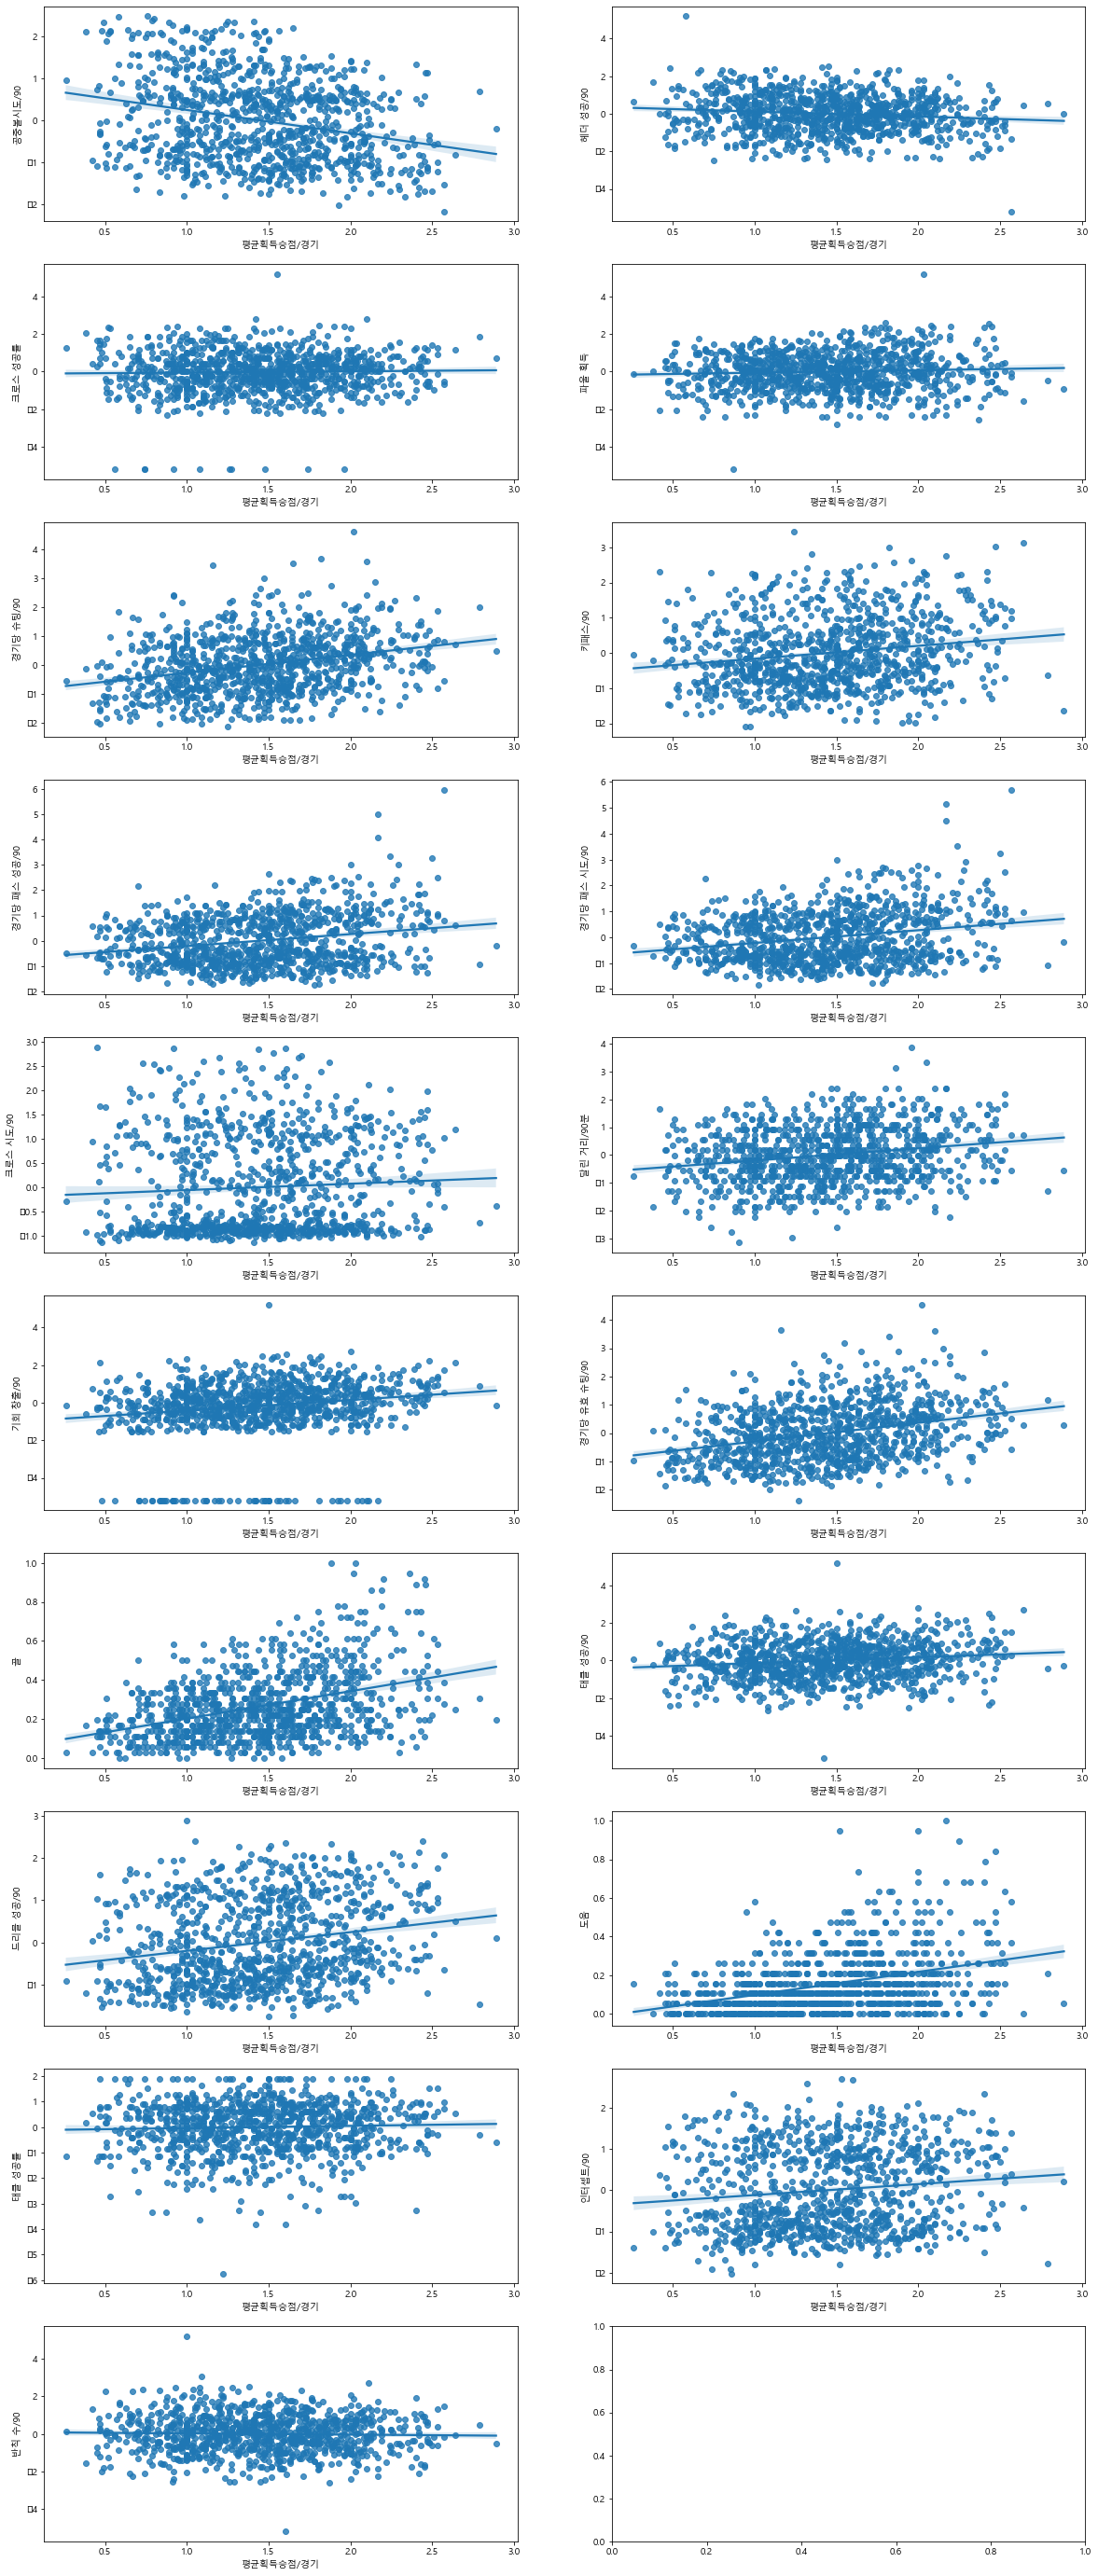

In [18]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [19]:
corr_dict_after_norm = {}

for feature in features:
    corr_dict_after_norm[f'크로스 성공률/{feature}'] = np.corrcoef(forward_df.loc[:,'크로스 성공률'],forward_df.loc[:,feature])[0][1]
    
sorted(corr_dict_after_norm.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('크로스 성공률/크로스 성공률', 1.0),
 ('크로스 성공률/태클 성공률', -0.216947464058169),
 ('크로스 성공률/드리블 성공/90', 0.07330437348732645),
 ('크로스 성공률/기회 창출/90', 0.07218387447456645),
 ('크로스 성공률/키패스/90', 0.044124550659364166),
 ('크로스 성공률/인터셉트/90', 0.038781762935857035),
 ('크로스 성공률/공중볼시도/90', -0.037765269028310976),
 ('크로스 성공률/크로스 시도/90', 0.03445782899988405),
 ('크로스 성공률/경기당 패스 시도/90', 0.032233967680183453),
 ('크로스 성공률/반칙 수/90', 0.03052566347617101),
 ('크로스 성공률/골', -0.02793542274778062),
 ('크로스 성공률/파울 획득', -0.02783878859816604),
 ('크로스 성공률/도움', 0.026392928787799322),
 ('크로스 성공률/달린 거리/90분', 0.020991551439689303),
 ('크로스 성공률/헤더 성공/90', -0.020454154008185815),
 ('크로스 성공률/태클 성공/90', 0.00921073670352573),
 ('크로스 성공률/경기당 슈팅/90', 0.004892357742651992),
 ('크로스 성공률/경기당 유효 슈팅/90', 0.0030456461322250195),
 ('크로스 성공률/경기당 패스 성공/90', -0.0021686868607216215)]

In [20]:
sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('공중볼시도/90', -0.2635664616800462),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('헤더 성공/90', -0.14336317747602786),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('반칙 수/90', -0.03516430428187815),
 ('크로스 성공률', 0.01034149433563985)]

In [21]:
# 상관계수가 높은 변수

# 전진선택법을 위한 변수의 우선순위 순 


good_feature_order = ['골','도움','경기당 유효 슈팅/90','공중볼시도/90','경기당 패스 시도/90',
                      '기회 창출/90','드리블 성공/90','크로스 성공률']

checkpoint_filepath = './tmp/'

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_feature_order[:i]],norm_forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(64,activation='relu')(inputs_layer)
    hidden2 = Dense(32,activation='relu')(hidden1)
    hidden3 = Dense(16,activation='relu')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=70,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)

['골']
Epoch 1/50
12/12 [==============================] - 1s 14ms/step - loss: 2.1879 - val_loss: 1.7594
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 1.8693 - val_loss: 1.4571
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 1.4961 - val_loss: 1.0765
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 1.0289 - val_loss: 0.6440
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5620 - val_loss: 0.2947
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2616 - val_loss: 0.1903
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2173 - val_loss: 0.1989
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2128 - val_loss: 0.1860
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2075 - val_loss: 0.1840
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2059 - val_loss: 0.1841
Epoch 11/50


12/12 [==============================] - 0s 4ms/step - loss: 0.1434 - val_loss: 0.1368
Epoch 16/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1415 - val_loss: 0.1366
Epoch 17/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1400 - val_loss: 0.1352
Epoch 18/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1386 - val_loss: 0.1354
Epoch 19/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1379 - val_loss: 0.1341
Epoch 20/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1376 - val_loss: 0.1352
Epoch 21/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1362 - val_loss: 0.1337
Epoch 22/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1350 - val_loss: 0.1340
Epoch 23/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1343 - val_loss: 0.1338
Epoch 24/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1337 - val_loss: 0.1342
Epoch 25/50
12/12 [===

12/12 [==============================] - 0s 4ms/step - loss: 0.1181 - val_loss: 0.1136
Epoch 29/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1184 - val_loss: 0.1141
Epoch 30/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1185 - val_loss: 0.1126
Epoch 31/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1161 - val_loss: 0.1139
Epoch 32/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1153 - val_loss: 0.1137
Epoch 33/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1155 - val_loss: 0.1110
Epoch 34/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1141 - val_loss: 0.1128
Epoch 35/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1147 - val_loss: 0.1118
Epoch 36/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1127 - val_loss: 0.1122
Epoch 37/50
12/12 [==============================] - 0s 4ms/step - loss: 0.1114 - val_loss: 0.1135
Epoch 38/50
12/12 [===

In [22]:
forward_mae

[0.3455372901877971,
 0.34526783492830054,
 0.3434952895809906,
 0.3063080214731621,
 0.2887439814601282,
 0.27602247605420127,
 0.2723391324221486,
 0.30627155102864656]

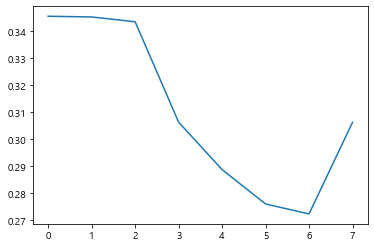

In [23]:
plt.plot(forward_mae)
plt.show()

In [24]:
good_features = good_feature_order[0:np.argmin(np.array(forward_mae))+1]
#good_features.append(good_feature_order[6])
good_features

['골',
 '도움',
 '경기당 유효 슈팅/90',
 '공중볼시도/90',
 '경기당 패스 시도/90',
 '기회 창출/90',
 '드리블 성공/90']

In [25]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_features],norm_forward_df.loc[:,target],test_size=0.2)

In [26]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(256,activation='swish')(inputs_layer)
hidden2 = Dense(512,activation='swish')(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(1024,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(2048,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dropout(0.1)(hidden5)
hidden7 = Dense(1024,activation='swish')(hidden6)
hidden8 = Dense(512,activation='swish')(hidden7)
hidden9 = Dense(256,activation='swish')(hidden8)
hidden10 = Dense(128,activation='swish')(hidden9)
hidden11 = Dense(4,activation='swish')(hidden10)
output = Dense(1,activation='linear')(hidden11)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=70,epochs=600,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
#model.save('./models/forward_nn.h5')

Epoch 1/600
12/12 [==============================] - 1s 24ms/step - loss: 19.0654 - val_loss: 14.5696
Epoch 2/600
12/12 [==============================] - 0s 11ms/step - loss: 12.7606 - val_loss: 10.4721
Epoch 3/600
12/12 [==============================] - 0s 11ms/step - loss: 9.0430 - val_loss: 7.3439
Epoch 4/600
12/12 [==============================] - 0s 11ms/step - loss: 6.2820 - val_loss: 5.0423
Epoch 5/600
12/12 [==============================] - 0s 10ms/step - loss: 4.3015 - val_loss: 3.4412
Epoch 6/600
12/12 [==============================] - 0s 10ms/step - loss: 2.9351 - val_loss: 2.3546
Epoch 7/600
12/12 [==============================] - 0s 10ms/step - loss: 2.0122 - val_loss: 1.6150
Epoch 8/600
12/12 [==============================] - 0s 10ms/step - loss: 1.3960 - val_loss: 1.1302
Epoch 9/600
12/12 [==============================] - 0s 10ms/step - loss: 0.9802 - val_loss: 0.8076
Epoch 10/600
12/12 [==============================] - 0s 10ms/step - loss: 0.7064 - val_loss: 0.

Epoch 82/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1254 - val_loss: 0.1351
Epoch 83/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1276 - val_loss: 0.1339
Epoch 84/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1277 - val_loss: 0.1421
Epoch 85/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1286 - val_loss: 0.1358
Epoch 86/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.1368
Epoch 87/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1263 - val_loss: 0.1431
Epoch 88/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1291 - val_loss: 0.1354
Epoch 89/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1228 - val_loss: 0.1377
Epoch 90/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1239 - val_loss: 0.1355
Epoch 91/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1245 - val_los

12/12 [==============================] - 0s 11ms/step - loss: 0.1260 - val_loss: 0.1369
Epoch 243/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1259 - val_loss: 0.1422
Epoch 244/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1266 - val_loss: 0.1405
Epoch 245/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1255 - val_loss: 0.1390
Epoch 246/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1231 - val_loss: 0.1475
Epoch 247/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1223 - val_loss: 0.1405
Epoch 248/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1232 - val_loss: 0.1367
Epoch 249/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1232 - val_loss: 0.1365
Epoch 250/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1218 - val_loss: 0.1341
Epoch 251/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1220 - val_loss: 0

12/12 [==============================] - 0s 10ms/step - loss: 0.1205 - val_loss: 0.1333
Epoch 403/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1184 - val_loss: 0.1334
Epoch 404/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1204 - val_loss: 0.1329
Epoch 405/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1210 - val_loss: 0.1364
Epoch 406/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1211 - val_loss: 0.1394
Epoch 407/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1208 - val_loss: 0.1414
Epoch 408/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1226 - val_loss: 0.1356
Epoch 409/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1236 - val_loss: 0.1376
Epoch 410/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1238 - val_loss: 0.1363
Epoch 411/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1219 - val_loss: 0

12/12 [==============================] - 0s 11ms/step - loss: 0.1178 - val_loss: 0.1343
Epoch 563/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1176 - val_loss: 0.1344
Epoch 564/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1184 - val_loss: 0.1330
Epoch 565/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1157 - val_loss: 0.1354
Epoch 566/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1180 - val_loss: 0.1345
Epoch 567/600
12/12 [==============================] - 0s 11ms/step - loss: 0.1202 - val_loss: 0.1330
Epoch 568/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1178 - val_loss: 0.1347
Epoch 569/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1181 - val_loss: 0.1346
Epoch 570/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1169 - val_loss: 0.1326
Epoch 571/600
12/12 [==============================] - 0s 10ms/step - loss: 0.1172 - val_loss: 0

In [27]:
model = load_model('./models/forward_nn.h5')

In [28]:
norm_forward_df['predict'] = model.predict(norm_forward_df.loc[:,['골','도움','경기당 유효 슈팅/90','공중볼시도/90','경기당 패스 시도/90','기회 창출/90','드리블 성공/90']])

# 모델 검정

In [29]:
residual = norm_forward_df['평균획득승점/경기'] - norm_forward_df['predict']

## 모형의 선형성 검정

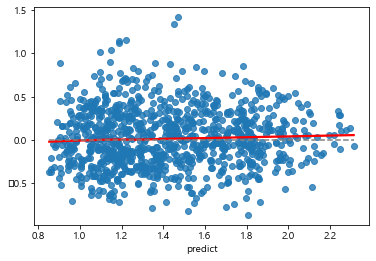

In [30]:
sns.regplot(norm_forward_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([norm_forward_df['predict'].values.min(), norm_forward_df['predict'].values.max()], [0, 0], '--', color='grey')

## 정규성 검정

In [31]:
stats.shapiro(residual)

ShapiroResult(statistic=0.9932886362075806, pvalue=0.00019335150136612356)

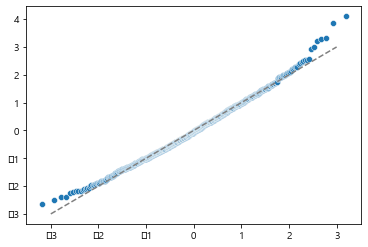

In [32]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 등분산성 검정

In [33]:
stats.levene(norm_forward_df['평균획득승점/경기'],norm_forward_df['predict'])

LeveneResult(statistic=125.92937685657498, pvalue=2.248162775426294e-28)

<AxesSubplot:>

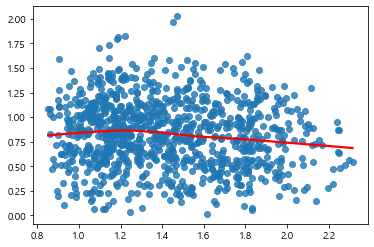

In [34]:
sns.regplot(norm_forward_df['predict'].values, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})